# Introduction to torchtuples

In this notebook we illustrate the most basic use of torchtuples to fit models.

For more general usage, see 02_general_usage.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchtuples
from torchtuples import Model
from torchtuples.practical import MLPVanilla

In [2]:
from sklearn.datasets import make_classification # to create a data set
from sklearn.model_selection import train_test_split

In [3]:
# to reproduce results
np.random.seed(1234)
_ = torch.manual_seed(4321)

## Make a data set

We create a binary classification data set with `make_classification` and split it in training, validation and testing.

The data set is standardized, so we require no more preprocessing. However, we need to set the data type to 'float32', as torch does not work for 'float64', and we need y to be a column vector as this is expected by `torch.nn.BCEWithLogitsLoss`

In [4]:
n = 10000
x_train, y_train = make_classification(n)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32').reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

## Make a torch net

Next, we need to make the torch net. For simplicity we will use `MLPVanilla` to make a two-hidden-layers MLP with 32 nodes in each layer, ReLU activation, batch norm and dropout of 0.1.

If you don't know how to make torch models, you shold see PyTorch has some [excellent tutorials](https://pytorch.org/tutorials/)

In [5]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1

net = MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [6]:
net

MLPVanilla(
  (net): Sequential(
    (0): LinearVanillaBlock(
      (linear): Linear(in_features=20, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1)
    )
    (1): LinearVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1)
    )
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Train model

We now define the loss function (binary cross-entropy) and the optimizer (Adma) and create a model. We can use optimizers form `torch`, but the `torchtuples.optim` module contrain wrappers to the same optimizers with some add functionality.

If we don't specify a `device`, the `Moded` will used gpu if avaiable.

In [7]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torchtuples.optim.Adam(lr=0.001)
model = Model(net, loss, optimizer)

We can now fit the data set, with an optional validation set

In [8]:
log = model.fit(x_train, y_train, batch_size=256, epochs=5, val_data=(x_val, y_val))

0:	[0s / 0s],		train_loss: 0.6232,	val_loss: 0.5740
1:	[0s / 0s],		train_loss: 0.5372,	val_loss: 0.4760
2:	[0s / 0s],		train_loss: 0.4583,	val_loss: 0.3986
3:	[0s / 0s],		train_loss: 0.3876,	val_loss: 0.3425
4:	[0s / 0s],		train_loss: 0.3443,	val_loss: 0.3061


the model keeps track of the trainig so one can continue

In [9]:
log = model.fit(x_train, y_train, batch_size=256, epochs=5, val_data=(x_val, y_val))

5:	[0s / 0s],		train_loss: 0.3073,	val_loss: 0.2835
6:	[0s / 0s],		train_loss: 0.2894,	val_loss: 0.2723
7:	[0s / 0s],		train_loss: 0.2741,	val_loss: 0.2625
8:	[0s / 0s],		train_loss: 0.2679,	val_loss: 0.2565
9:	[0s / 0s],		train_loss: 0.2639,	val_loss: 0.2510


The progress is store in `log` or `model.log`, and we can create a data frame or plot the results

In [10]:
log.to_pandas().head()

,train_loss,val_loss
0,0.623153,0.573984
1,0.537241,0.475984
2,0.458258,0.398643
3,0.387587,0.342534
4,0.344325,0.306090


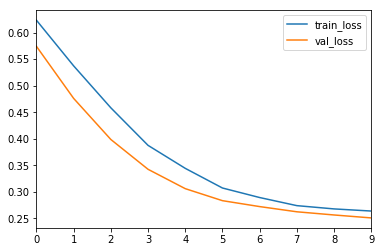

In [11]:
log.plot()

## Predictions

We can now used the `predict` method on our test set

In [12]:
preds = model.predict(x_test)

In [13]:
type(preds)

numpy.ndarray

However, to get probability estimates, we need to pass the results though a `sigmoid function`. It is easier to do this with a torch tensor than a numpy array, so we pass `numpy=False` to the predict method

In [14]:
preds = model.predict(x_test, numpy=False).sigmoid().numpy()

We can now get the test accuracy:

In [15]:
((preds > 0.5) == y_test).mean()

0.894